In [ ]:
# Unpacking best-performing text classiffier
# April 2025
# Violeta Berdejo-Espinola

In [ ]:
%pip install mpu scikit-learn matplotlib numpy embetter imblearn scipy shap sentence_transformers stop-words WordCloud

# read data

In [1]:
import mpu

# raw corpus

x = mpu.io.read('../data/v2/corpus_raw.pickle')

# y

y = mpu.io.read('../data/v2/y.pickle')

# calculate weights

from sklearn.utils.class_weight import compute_class_weight
import numpy as np

classes = np.unique(y)
weights = compute_class_weight('balanced', classes=classes, y=y)
class_weight_dict = dict(zip(classes, weights))

In [2]:
classes, weights

(array([0, 1]), array([ 0.50399564, 63.06818182]))

# best models


In [3]:
from imblearn.pipeline import make_pipeline 

from embetter.text import SentenceEncoder

from sklearn.svm import SVC

from sklearn.model_selection import cross_val_predict, StratifiedKFold

from sklearn.metrics import recall_score, precision_score, f1_score
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix

import numpy as np

def train_eval_best_model(x_train, y_train, x_test, y_test, kfold, C):
    
    """"
    Train and test model
    
    Parameters:
    -----------
    x_train, x_test: list of strings
        raw text to create embeddings
    y_train_y_test: array 
        binary labels
    text_length: string 
        indicating whther it is 'text and asbtract' or 'text, asbtract, and main text'
    kfold: int
        indicating number of folds for cross validation
    embedding_model: string
        instantiation of embedding model
    random_state: int
        seed
    C: int
        strength of regularisation parametre

        
    Returns:
    --------
    Dictionary with scores.
    Aray of predictions and predicted probabilities.
    Log losss values for test and train set.
    Array of test set predicitons
    Model object
    AIC value
    """
    
    pipeline = make_pipeline(
        SentenceEncoder('paraphrase-multilingual-mpnet-base-v2'),
        SVC(kernel='linear', class_weight=class_weight_dict, probability=True, C=C)

    )
    
    #train model
    y_train_pred_cv = cross_val_predict(pipeline, x_train, y_train, cv=StratifiedKFold(kfold), method='predict') 

    pipeline.fit(x_train, y_train)
    
    # make predictions
    y_train_pred = pipeline.predict(x_train)

    y_test_pred = pipeline.predict(x_test)
    
    y_train_pred_proba = pipeline.predict_proba(x_train) 
    
    y_test_pred_proba = pipeline.predict_proba(x_test)  
    
    # log loss 
    logloss_tr = log_loss(y_train, y_train_pred_proba) 
    
    logloss_ts = log_loss(y_test, y_test_pred_proba)
    
    # model object -svm / logreg-
    model = pipeline.steps[-1][1]  

    # get model scores 
    scores = {
        'CV': kfold,
        'F1_tr_cv': round(f1_score(y_train, y_train_pred_cv), 3),
        'F1_tr': round(f1_score(y_train, y_train_pred), 3),
        'F1_ts': round(f1_score(y_test, y_test_pred), 3),
        'Precision_tr_cv': round(precision_score(y_train, y_train_pred_cv), 3),
        'Precision_tr': round(precision_score(y_train, y_train_pred), 3),
        'Precision_ts': round(precision_score(y_test, y_test_pred), 3),
        'Recall_tr_cv': round(recall_score(y_train, y_train_pred_cv), 3),
        'Recall_tr': round(recall_score(y_train, y_train_pred), 3),
        'Recall_ts': round(recall_score(y_test, y_test_pred), 3)
        }
    
    print(f'loss training set: {logloss_tr}, \nloss test set {logloss_ts}')
    print(f'confusion matrix train set:\n{confusion_matrix(y_train, pipeline.predict(x_train))}')
    print(f'confusion matrix test set:\n{confusion_matrix(y_test, pipeline.predict(x_test))}') 
 
    return scores, y_train_pred, y_test_pred, y_train_pred_proba, y_test_pred_proba, logloss_tr, logloss_ts, model

/Users/uqvberde/Projects/classifier_spanish/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# train-test model on different train-test partitions


run on a few different train-test partitions, then report the average with the standard error.
I should see greater performance with more data, but also lower variance across the different random samples

In [4]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=24, stratify=y)

scores1, y_train_pred1, y_test_pred1, y_train_pred_proba1, y_test_pred_proba1, logloss_tr1, logloss_ts1, model1= train_eval_best_model(x_train, y_train, x_test, y_test, 2, 0.01)

print(scores1)
print(np.mean(y_test_pred1 == y_test))

loss training set: 0.031368761552602396, 
loss test set 0.036593136036280345
confusion matrix train set:
[[3364 1041]
 [   0   35]]
confusion matrix test set:
[[843 258]
 [  1   8]]
{'CV': 2, 'F1_tr_cv': 0.053, 'F1_tr': 0.063, 'F1_ts': 0.058, 'Precision_tr_cv': 0.027, 'Precision_tr': 0.033, 'Precision_ts': 0.03, 'Recall_tr_cv': 0.943, 'Recall_tr': 1.0, 'Recall_ts': 0.889}
0.7666666666666667


In [5]:
model1

SVC(C=0.01, class_weight={0: 0.5039956411187795, 1: 63.06818181818182},
    kernel='linear', probability=True)

In [6]:
y_test_pred1

array([0, 1, 1, ..., 0, 0, 0])

In [ ]:
# from scipy import stats

# stats.sem([logloss_ts1, logloss_ts2, logloss_ts3, logloss_ts])

# classification labels

In [7]:
import pandas as pd

dat = pd.DataFrame({"x_test":x_test,
                    "y_test":y_test,
                    "y_pred":y_test_pred1})

dat['prediction'] = np.select(
    [
        (dat['y_test'] == 0) & (dat['y_pred'] == 0),  # True Negative
        (dat['y_test'] == 1) & (dat['y_pred'] == 1),  # True Positive
        (dat['y_test'] == 0) & (dat['y_pred'] == 1),  # False Positive
        (dat['y_test'] == 1) & (dat['y_pred'] == 0)   # False Negative
    ],
    ["tn", "tp", "fp", "fn"],
    default="unknown"
)

# create dfs

tp = dat.loc[dat['prediction'] == "tp"]
tn = dat.loc[dat['prediction']== "tn"]
fp = dat.loc[dat['prediction']== "fp"]
fn = dat.loc[dat['prediction']== "fn"] # zero

# create lists with text only

tp_text = tp['x_test']
tn_text = tn['x_test']
fp_text = fp['x_test']

dat

,x_test,y_test,y_pred,prediction
0,Distribución y taxonomía de pyrgophorus platyr...,0,0,tn
1,Impacto de la cosecha y destino de los residuo...,0,1,fp
2,Primeros datos sobre migración e hibernación d...,0,1,fp
3,Contribución al conocimiento de enemigos natur...,0,0,tn
4,Nueva especie de echeveria (crassulaceae) del ...,0,0,tn
...,...,...,...,...
1105,Nueva especie del quitón lepidochitona (polypl...,0,0,tn
1106,Variabilidad genética de brycon henni (characi...,0,0,tn
1107,Patrón temporal de vocalizaciones y territorio...,0,0,tn
1108,Reconstrucción de 350 años de precipitación pa...,0,0,tn


# explainability

In [8]:
import shap
from sentence_transformers import SentenceTransformer

classes = np.unique(y)

# encode text
encoder = SentenceTransformer('paraphrase-multilingual-mpnet-base-v2')
X = encoder.encode(x)
print(f"Encoded data shape: {X.shape}")

Encoded data shape: (5550, 768)


In [9]:
# define SHAP masker 
masker = shap.maskers.Text(tokenizer=r"\W+") # split on non-word characters

# define and prediction function
def prediction_function(text_batch): #ensure text_batch is a list of strings, SHAP might pass numpy arrays
    
    """Encodes perturbed text into embeddings and returns class probabilities."""
    
    if isinstance(text_batch, np.ndarray):
        text_batch = text_batch.tolist()
    try:
        embeddings = encoder.encode(text_batch) 
        probas = model1.predict_proba(embeddings)

        return probas#[:, 0]  # shape: (batch_size,)
   
    except Exception as e:
        print(f"Error during prediction function execution: {e}")
        # Return a default value or re-raise depending on desired handling
        # Returning zeros matching expected output shape might help SHAP proceed
        # return shape (batch_size, num_classes)
        return np.zeros((len(text_batch), len(classes)))

# initialize SHAP explainer for logreg
explainer = shap.Explainer(prediction_function, masker, output_names=["Class 0", "Class 1"]) 
print("SHAP Explainer with probability values initialized.")

# define score function
def score_function(text_batch):
    
    """Encodes perturbed text into embeddings and returns class probabilities."""
    
    if isinstance(text_batch, np.ndarray):
        text_batch = text_batch.tolist()
    try:
        embeddings = encoder.encode(text_batch) 
        # probas = model1.predict_proba(embeddings)

        # return probas#[:, 0]  # shape: (batch_size,)
        scores = model1.decision_function(embeddings)
        return scores
    except Exception as e:
        print(f"Error during prediction function execution: {e}")

        # return shape (batch_size, num_classes)
        return np.zeros((len(text_batch), len(classes)))

# initialize SHAP explainer for svm
score_explainer = shap.Explainer(score_function, masker)
print("SHAP Explainer with log odd values initialized.")

SHAP Explainer with probability values initialized.
SHAP Explainer with log odd values initialized.


# explain positive instances

In [10]:
print(f"\nExplaining a positive instance.")
shap_values_pos = score_explainer(tp_text[:]) #

print("SHAP values calculated.")
# shap.plots.text(shap_values_pos)


Explaining a positive instance.


PartitionExplainer explainer: 9it [00:58,  7.30s/it]                       

SHAP values calculated.


In [11]:
# save shap.plot as html

with open('../results/v2/shap_plot_text_true_positive_24.html', 'w') as file:
     file.write(shap.plots.text(shap_values_pos, display=False))

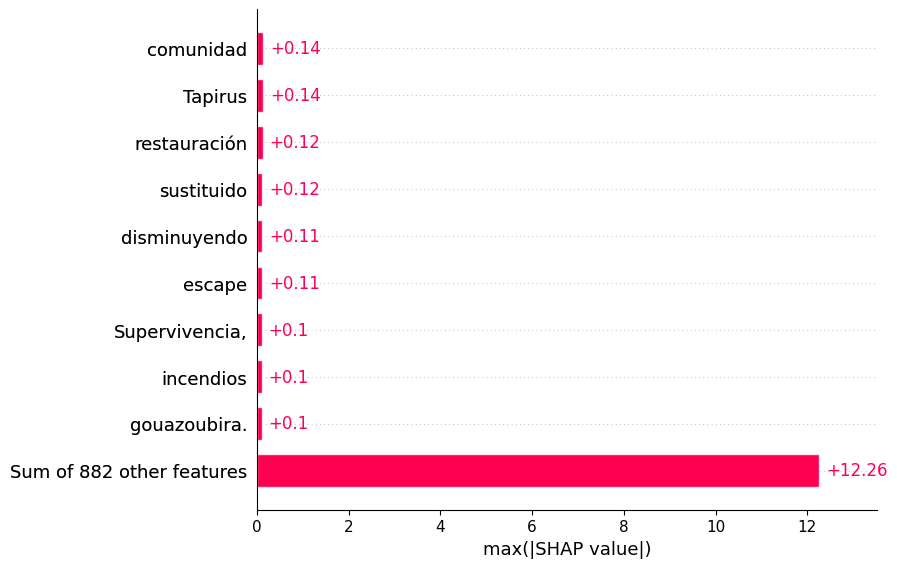

In [ ]:
# features having the largest impact in positive predictions

import matplotlib.pyplot as plt

shap_plot = shap.plots.bar(shap_values_pos.abs.max(0), show=False)

plt.savefig("../results/v2/shap_summary_true_positives_24.png",dpi=700, format="png", bbox_inches="tight")

plt.show()

In [13]:
shap_values_pos

.values =
array([array([ 2.27260400e-02,  2.44033496e-02,  2.02740905e-03,  2.02740905e-03,
               3.07771966e-02,  3.07771966e-02,  6.26650936e-02,  3.45732244e-02,
              -6.85730972e-03, -6.85730972e-03, -1.48512331e-02, -1.48512331e-02,
              -8.67192123e-03, -8.67192123e-03, -8.67192123e-03, -8.67192123e-03,
               2.48212211e-03,  2.48212211e-03,  2.48212211e-03,  2.48212211e-03,
              -5.00835832e-03, -5.00835832e-03, -2.28737584e-02,  2.06075005e-03,
              -4.81636044e-02, -4.81636044e-02, -1.29411456e-02, -1.29411456e-02,
              -1.25262883e-02, -1.25262883e-02, -1.25262883e-02, -1.25262883e-02,
              -7.91614649e-03, -7.91614649e-03, -5.09311086e-04, -5.09311086e-04,
              -6.40704003e-03, -6.40704003e-03, -2.30063010e-02, -2.30063010e-02,
               1.48457344e-02,  1.48457344e-02,  1.48457344e-02,  1.48457344e-02,
               1.78836263e-02,  9.61151799e-03,  3.55385518e-02,  1.13634503e-01,
      

# explain negative instances

In [ ]:
print(f"\nExplaining a negative instance")

shap_values_neg = score_explainer(tn_text[:])

print("SHAP values calculated.")

# shap.plots.text(shap_values_neg)


Explaining a negative instance


PartitionExplainer explainer: 844it [1:26:00,  6.13s/it]                           


SHAP values calculated.


In [19]:
# save shap.plot as html

import matplotlib.pyplot as plt

with open('../results/v2/shap_plot_text_true_negatives_24.html', 'w') as file:
     file.write(shap.plots.text(shap_values_neg, display=False))

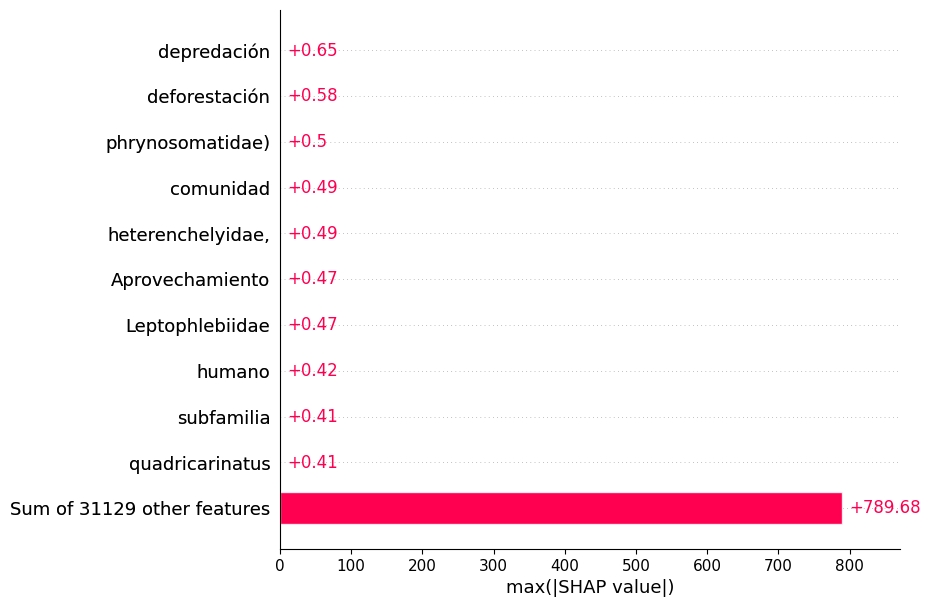

In [20]:
# features having the largest impact in positive predictions

shap_plot = shap.plots.bar(shap_values_neg.abs.max(0), show=False, max_display=11)

plt.savefig("../results/v2/shap_summary_true_negatives_24.png",dpi=700, format="png", bbox_inches="tight")

plt.show()

# explain false positves

In [14]:
print(f"\nExplaining a false positive instances")

shap_values_false_pos = score_explainer(fp_text[:])

print("SHAP values calculated.")

# shap.plots.text(shap_values_false_pos)


Explaining a false positive instances


PartitionExplainer explainer: 259it [24:43,  5.77s/it]                         

SHAP values calculated.


In [15]:
# save shap.plot as html

import matplotlib.pyplot as plt
from IPython.core.display import HTML

with open('../results/v2/shap_plot_text_false_positives_24.html', 'w') as file:
     file.write(shap.plots.text(shap_values_false_pos, display=False))

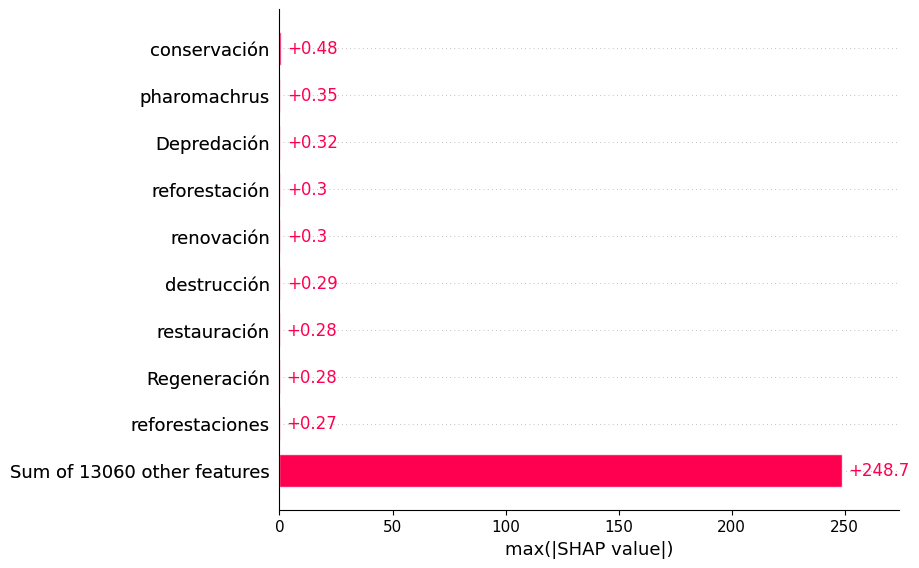

In [17]:
# features having the largest impact in positive predictions

shap_plot = shap.plots.bar(shap_values_false_pos.abs.max(0), show=False)

plt.savefig("../results/v2/shap_plot_false_positives_24.png",dpi=700, format="png", bbox_inches="tight")

plt.show()

# error analysis

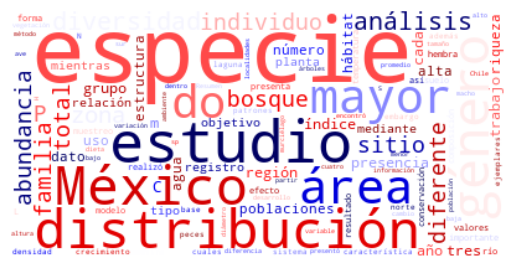

(<wordcloud.wordcloud.WordCloud at 0x36adba2d0>,
 shape: (1, 1_000)
 ┌─────────┬──────────┬──────────────┬──────────┬───┬──────────┬──────────┬──────────┬──────────────┐
 │ especie ┆ estudio  ┆ distribución ┆ México   ┆ … ┆ pez      ┆ suroeste ┆ anterior ┆ Caracterizac │
 │ ---     ┆ ---      ┆ ---          ┆ ---      ┆   ┆ ---      ┆ ---      ┆ ---      ┆ ión          │
 │ f64     ┆ f64      ┆ f64          ┆ f64      ┆   ┆ f64      ┆ f64      ┆ f64      ┆ ---          │
 │         ┆          ┆              ┆          ┆   ┆          ┆          ┆          ┆ f64          │
 ╞═════════╪══════════╪══════════════╪══════════╪═══╪══════════╪══════════╪══════════╪══════════════╡
 │ 1.0     ┆ 0.278937 ┆ 0.234662     ┆ 0.234029 ┆ … ┆ 0.009488 ┆ 0.009488 ┆ 0.009488 ┆ 0.009488     │
 └─────────┴──────────┴──────────────┴──────────┴───┴──────────┴──────────┴──────────┴──────────────┘)

In [22]:
from wordcloud import WordCloud

from stop_words import get_stop_words

import matplotlib.pyplot as plt
%matplotlib inline

import polars as pl

# true positive

def create_wordcloud(text, name):
    stop_words = get_stop_words('spanish')
    
    wordcloud = WordCloud(background_color="white", colormap='seismic_r', max_words=1000, stopwords=stop_words).generate(' '.join(text))
    
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()
    word_freq = wordcloud.words_
    word_freq = pl.DataFrame(word_freq)
    # wordcloud.to_file(f'../results/v2/wordcloud_{name}.png')
    # word_freq.write_csv('../results/v2/word_relative_frequency_tn.csv')
    
    return wordcloud, word_freq
    
create_wordcloud(tn_text, 'tn')

# performance plots


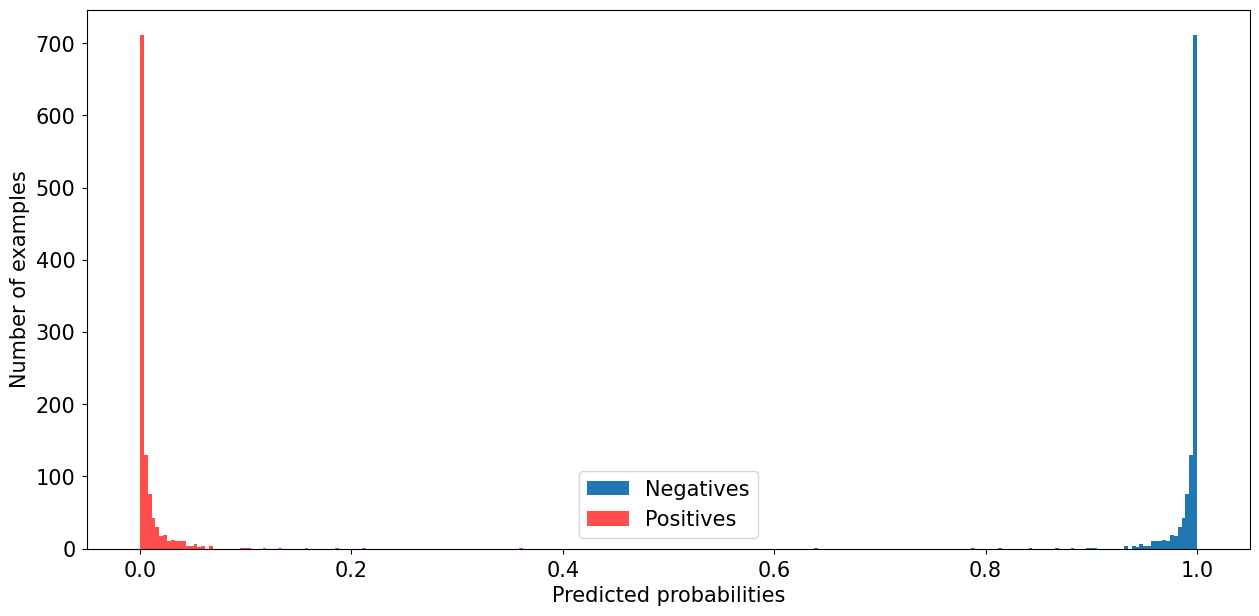

In [23]:
import matplotlib.pyplot as plt

y_pred_ts_p = y_test_pred_proba1[:,1] # subset class of interest --> 1d array
y_pred_ts_n = y_test_pred_proba1[:,0]

plt.figure(figsize=(15,7))
plt.hist(y_pred_ts_n, bins=100, label='Negatives')
plt.hist(y_pred_ts_p, bins=100, label='Positives', alpha=0.7, color='r')
plt.xlabel('Predicted probabilities', fontsize=15)
plt.ylabel('Number of examples', fontsize=15)
plt.legend(fontsize=15)
plt.tick_params(axis='both', labelsize=15, pad=5)
# plt.savefig('../results/model_scores/predicted_proba_logreg_ts.png', dpi=800)
plt.show() 


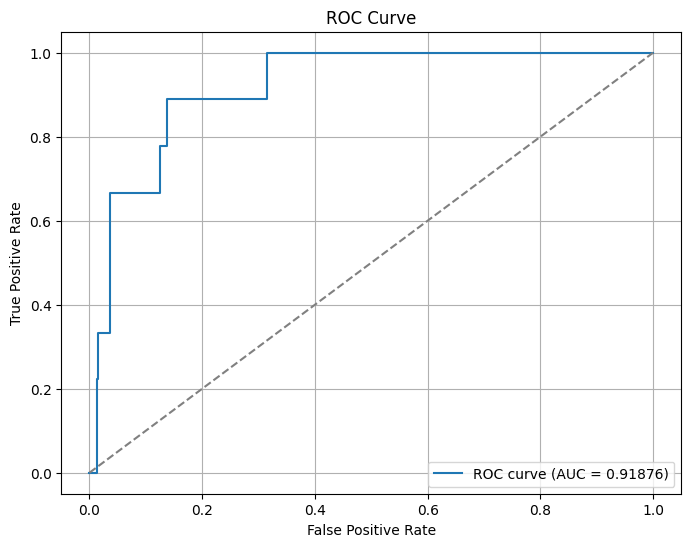

In [24]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# True labels and predicted probabilities for the positive class
fpr, tpr, thresholds = roc_curve(y_test, y_pred_ts_p)
auc_score = roc_auc_score(y_test, y_pred_ts_p)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc_score:.5f})')
plt.plot([0,1], [0,1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
# plt.savefig('../results/v2/roc_curve.png', dpi=1000)
plt.show()

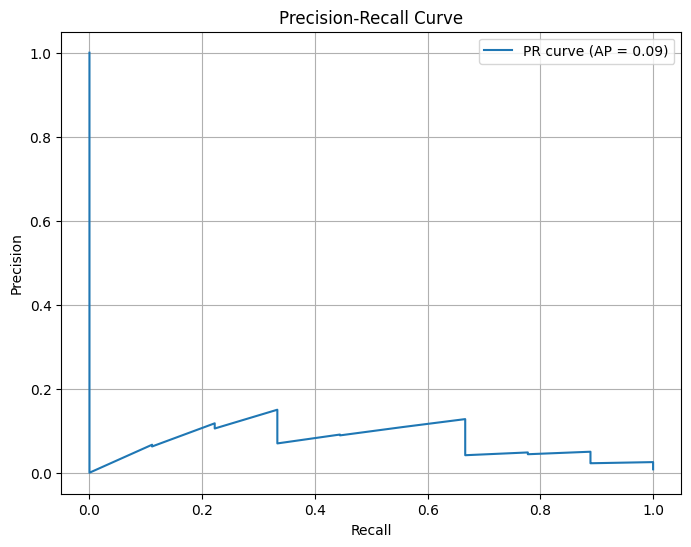

In [25]:
from sklearn.metrics import precision_recall_curve, average_precision_score

y_true = y_test

precision, recall, thresholds = precision_recall_curve(y_true, y_pred_ts_p)
ap_score = average_precision_score(y_true, y_pred_ts_p)

plt.figure(figsize=(8,6))
plt.plot(recall, precision, label=f'PR curve (AP = {ap_score:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()